# Interpolated Conditional KDE
The usage case of the interpolated conditional KDE, with respect to the ordinary
one is when the data has some of its dimensions inherently conditional.

Instead of having samples from a full distribution $P(x, y, z, w)$,
we might have samples of $P(x, y | z, w)$ for different values of $z$ and $w$.
Values of $(z, w)$ are in the most common scenario given on a grid. 
In the case we have information about $P(z, w)$, we might be able to use
`ConditionalGaussianKernelDensity`, however this is not always the case.

`InterpolatedConditionalKernelDensity` comes into play if one would like to 
sample / calculate $P(x, y | z, w)$ for some parameters not available on the grid, 
or additionally condition on $y$ for instance, and get $P(x | y, z, w)$.

For this particular example, the code then implements:

- `linear` or `nearest` interpolation for grid $(z, w)$,
- fitting of a conditional KDE for $P(x, y | z, w)$, for every point on the grid.

Thus when calculating $P(x | y, z, w)$, point $(z, w)$ is interpolated from the grid,
and conditional on $y$ is calculated by slicing through $P(x, y | z, w)$. 
At the moment, extrapolation is not supported.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from conditional_kde import InterpolatedConditionalKernelDensity

In this example we will investigate the following model:
$$ P(x, \mu | \sigma) = P(\mu) \cdot P(x | \mu, \sigma)$$
$$ P(x, \mu | \sigma) = \frac{1}{5 \sqrt{2\pi}} \exp\left(-\frac{1}{2} \frac{(\mu - 5)^2}{5^2}\right) \cdot \frac{1}{\sigma\sqrt{2\pi}} \exp\left(-\frac{1}{2} \frac{(x - \mu)^2}{\sigma}\right) \, .$$

Thus, for parameter $\sigma$ no prior is given, and it will be defined on a grid $\sigma \in [0.5, 1.0, 2.0, 5.0]$.

In [2]:
sigma = [0.5, 1.0, 2.0, 5.0]
N = 100000
data = []
for s in sigma:
    samples = np.empty((N, 2))
    for i in range(N):
        mu = np.random.normal(5., 5., 1).squeeze()
        x = np.random.normal(mu, s, 1).squeeze()
        samples[i, :] = [x, mu]
    data.append(samples)

(-10.0, 20.0)

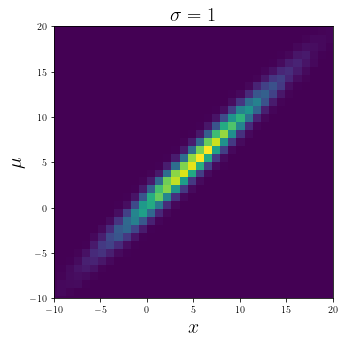

In [3]:
plt.figure(figsize = (5, 5))
plt.hist2d(data[1][:, 0], data[1][:, 1], bins = 50)
plt.xlabel("$x$", fontsize = 20)
plt.ylabel("$\mu$", fontsize = 20)
plt.title("$\sigma = 1$", fontsize = 20);
plt.xlim([-10, 20])
plt.ylim([-10, 20])

## Interpolation
Here we are investigating interpolation for the inherently conditional dimensions, in our case $\sigma$.
We firstly deal with `interpolation_method = "linear"`, and later show an example for the `"nearest"` case.

In [4]:
kde = InterpolatedConditionalKernelDensity().fit(
    data, 
    inherent_features = ["sigma"], 
    features = ["x", "mu"], 
    interpolation_points = {"sigma": sigma}, 
    interpolation_method = "linear",
)

Now let's firstly interpolate for different $\sigma$.

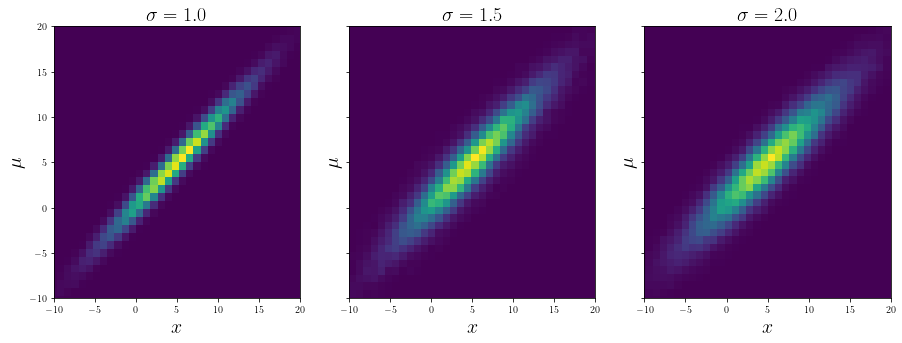

In [5]:
samples = kde.sample(
    inherent_conditionals = {"sigma": 1.5},
    conditionals = None, # no other conditionals
    n_samples = 100000,
)

fig, axes = plt.subplots(1, 3, sharey = True, figsize = (15, 5))
for ax, s, d in zip(axes, [1.0, 1.5, 2.0], [data[1], samples, data[2]]):
    ax.hist2d(d[:, 0], d[:, 1], bins = 50)
    ax.set_xlabel("$x$", fontsize = 20)
    ax.set_ylabel("$\mu$", fontsize = 20)
    ax.set_title(f"$\sigma = {s}$", fontsize = 20)
    ax.set_xlim([-10, 20])
    ax.set_ylim([-10, 20])

On the left and the right are two close distributions from the data, and in the middle the interpolated and sampled distribution for the value of $\sigma$ between the two. Let's repeat the procedure for another choice of $\sigma$:

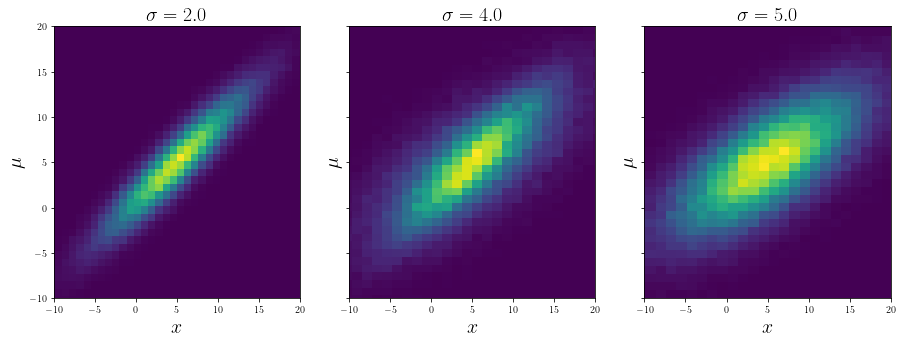

In [6]:
samples = kde.sample(
    inherent_conditionals = {"sigma": 4.0},
    conditionals = None, # no other conditionals
    n_samples = 100000,
)

fig, axes = plt.subplots(1, 3, sharey = True, figsize = (15, 5))
for ax, s, d in zip(axes, [2.0, 4.0, 5.0], [data[2], samples, data[3]]):
    ax.hist2d(d[:, 0], d[:, 1], bins = 50)
    ax.set_xlabel("$x$", fontsize = 20)
    ax.set_ylabel("$\mu$", fontsize = 20)
    ax.set_title(f"$\sigma = {s}$", fontsize = 20)
    ax.set_xlim([-10, 20])
    ax.set_ylim([-10, 20])

For the same example, if the `interpolation_method = "nearest"`:

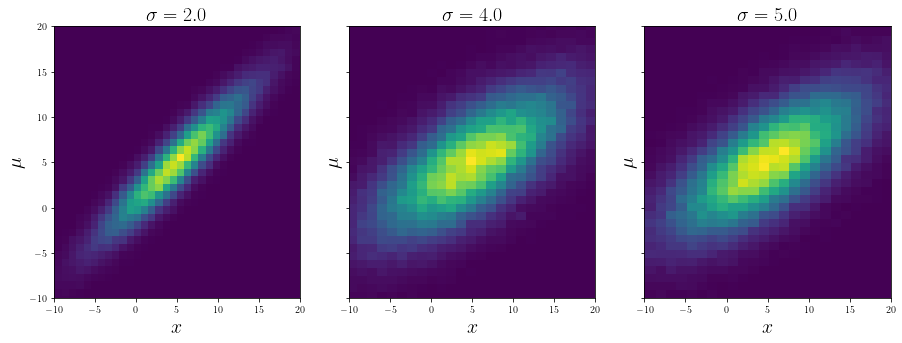

In [7]:
kde = InterpolatedConditionalKernelDensity().fit(
    data, 
    inherent_features = ["sigma"], 
    features = ["x", "mu"], 
    interpolation_points = {"sigma": sigma}, 
    interpolation_method = "nearest",
)

samples = kde.sample(
    inherent_conditionals = {"sigma": 4.0},
    conditionals = None, # no other conditionals
    n_samples = 100000,
)

fig, axes = plt.subplots(1, 3, sharey = True, figsize = (15, 5))
for ax, s, d in zip(axes, [2.0, 4.0, 5.0], [data[2], samples, data[3]]):
    ax.hist2d(d[:, 0], d[:, 1], bins = 50)
    ax.set_xlabel("$x$", fontsize = 20)
    ax.set_ylabel("$\mu$", fontsize = 20)
    ax.set_title(f"$\sigma = {s}$", fontsize = 20)
    ax.set_xlim([-10, 20])
    ax.set_ylim([-10, 20])

As expected, in this case the code picked the (linearly) nearest distribution and sampled from it.

## Interpolation + slicing
Now let's also consider the case where we would like to additionally condition on $\mu$. 

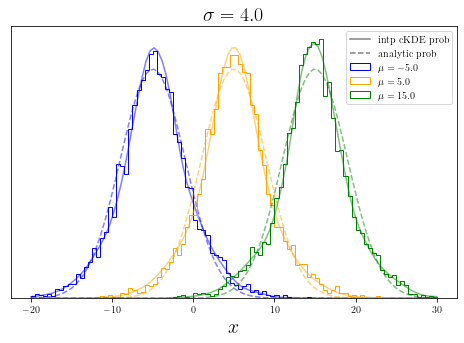

In [8]:
kde = InterpolatedConditionalKernelDensity().fit(
    data, 
    inherent_features = ["sigma"], 
    features = ["x", "mu"], 
    interpolation_points = {"sigma": sigma}, 
    interpolation_method = "linear",
)

plt.figure(figsize = (8, 5))
mu_s = [-5., 5., 15.]
colors = ["blue", "orange", "green"]
mini, maxi = -20, 30
x = np.linspace(mini, maxi, 100)
for i, (mu, c) in enumerate(zip(mu_s, colors)):
    # plotting actual values of probabilities
    log_probs = kde.score_samples(
        np.stack([x, np.ones(len(x)) * mu], axis = -1),
        inherent_conditionals = {"sigma": 4.0},
        conditional_features = ["mu"],
    )
    label = "intp cKDE prob" if i == 0 else None
    plt.plot(x, np.exp(log_probs), color = c, alpha = 0.5, label = label)

    # plotting analytical probabilities
    probs = 1 / (np.sqrt(2 * np.pi) * 4.0) * np.exp(-0.5 / 16.0 * (x - mu)**2)
    label = "analytic prob" if i == 0 else None
    plt.plot(x, probs, color = c, linestyle = "--", alpha = 0.5, label = label)

    # plotting samples
    samples = kde.sample(
        inherent_conditionals = {"sigma": 4.0},
        conditionals = {"mu": mu},
        n_samples = 10000, 
        keep_dims = False,
    )
    plt.hist(
        samples, 
        bins = 100,
        density = True, 
        histtype = "step",
        color = c,
        label = f"$\mu = {mu}$", 
        range = (mini, maxi)
    )
plt.yticks([])
plt.xlabel("$x$", fontsize = 20)
plt.title("$\sigma = 4.0$", fontsize = 20)

plt.legend()
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color("black")
leg.legendHandles[1].set_color("black")

Here interpolated conditional probabilities are shown with continuos lines, analytic probabilities with dashed lines, together with histograms of samples. One can see that continuos lines follow the histograms, however they both slightly differ from the actual analytic probabilities. This is expected, as the analytic function is not a simple linear interpolation between two values of $\sigma$.